# Cryptocurrency Price Prediction with ARIMA, LSTM, and Prophet
This notebook demonstrates the implementation of three powerful time series forecasting models to predict cryptocurrency price movements.

## 1. Import Required Libraries
Import necessary libraries for data processing, visualization, and model implementation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Time series and statistical tools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Try importing Deep learning libraries
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    tensorflow_available = True
except ImportError:
    tensorflow_available = False
    print("Warning: TensorFlow not available. Using sklearn alternatives for neural networks.")

# Try importing Prophet
try:
    from prophet import Prophet
    prophet_available = True
except ImportError:
    prophet_available = False
    print("Warning: Prophet not available. Install with: pip install prophet")

# Display settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("Libraries imported successfully!")
if not tensorflow_available:
    print("Note: LSTM cells will be adapted for sklearn")
if not prophet_available:
    print("Note: Prophet cells will be skipped")

2026-02-08 11:09:16.224739: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-08 11:09:17.264605: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-08 11:09:21.009681: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Libraries imported successfully!


## 2. Load and Explore Time Series Data
Load historical price data and perform exploratory analysis.

In [2]:
# Load data
data_path = '../data/processed/processed_data.csv'
df = pd.read_csv(data_path)

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (3650, 7)

First few rows:
                 date coin    open    high     low   close       volume
0 2025-01-23 05:30:00  ADA  0.9827  1.0118  0.9512  0.9867  192569354.5
1 2025-01-24 05:30:00  ADA  0.9867  1.0100  0.9636  0.9712  124426928.3
2 2025-01-25 05:30:00  ADA  0.9712  0.9919  0.9642  0.9766   56721656.8
3 2025-01-26 05:30:00  ADA  0.9766  1.0003  0.9515  0.9530   73197919.3
4 2025-01-27 05:30:00  ADA  0.9530  0.9587  0.8568  0.9345  257950415.8

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3650 non-null   datetime64[ns]
 1   coin    3650 non-null   object        
 2   open    3650 non-null   float64       
 3   high    3650 non-null   float64       
 4   low     3650 non-null   float64       
 5   close   3650 non-null   float64       
 6   volume  3650 non-null   float64       
dtypes: d

In [3]:
# Get all coins from data - model runs for all coins
COINS = sorted(df['coin'].unique().tolist())
print(f"Available coins ({len(COINS)}): {COINS}\n")

# Build coin_data for each - downstream cells use first coin for inline EDA
# To run full model comparison for ALL coins, use: model_comparison.py (no --coin arg)
all_coin_data = {}
for c in COINS:
    cd = df[df['coin'] == c].copy().sort_values('date').reset_index(drop=True)
    all_coin_data[c] = cd
    print(f"{c}: {len(cd)} records, {cd['date'].min().date()} to {cd['date'].max().date()}")

# Use first coin for notebook EDA/visualization - change index to analyze another
coin = COINS[0]
coin_data = all_coin_data[coin]

print(f"\n--- Using {coin} for inline analysis below ---")
print(f"Total records for {coin}: {len(coin_data)}")
print(f"Date range: {coin_data['date'].min()} to {coin_data['date'].max()}")
print(f"\nPrice Statistics for {coin}:")
print(coin_data['close'].describe())

Available coins (10): ['ADA', 'BNB', 'BTC', 'DOGE', 'DOT', 'ETH', 'LTC', 'SOL', 'TRX', 'XRP']

ADA: 365 records, 2025-01-23 to 2026-01-22
BNB: 365 records, 2025-01-23 to 2026-01-22
BTC: 365 records, 2025-01-23 to 2026-01-22
DOGE: 365 records, 2025-01-23 to 2026-01-22
DOT: 365 records, 2025-01-23 to 2026-01-22
ETH: 365 records, 2025-01-23 to 2026-01-22
LTC: 365 records, 2025-01-23 to 2026-01-22
SOL: 365 records, 2025-01-23 to 2026-01-22
TRX: 365 records, 2025-01-23 to 2026-01-22
XRP: 365 records, 2025-01-23 to 2026-01-22

--- Using ADA for inline analysis below ---
Total records for ADA: 365
Date range: 2025-01-23 05:30:00 to 2026-01-22 05:30:00

Price Statistics for ADA:
count    365.000000
mean       0.673545
std        0.166480
min        0.333500
25%        0.577300
50%        0.698000
75%        0.805200
max        1.135000
Name: close, dtype: float64


**To run ARIMA, LSTM, and Prophet for ALL coins**, execute the script from the `models/` folder:
```bash
cd models && python model_comparison.py
```
Or for specific coins: `python model_comparison.py --coin BTC ETH SOL`

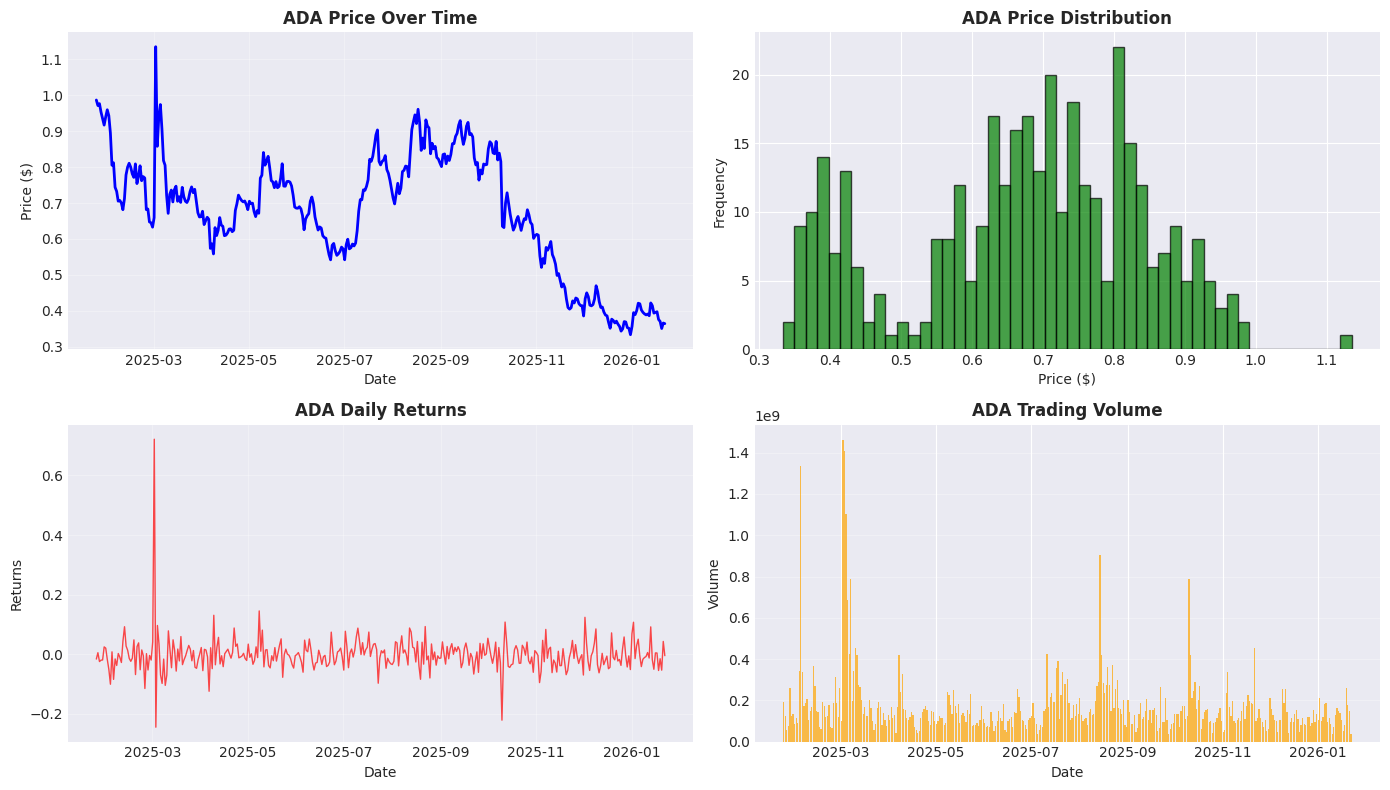

In [4]:
# Visualize price trends
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Price over time
axes[0, 0].plot(coin_data['date'], coin_data['close'], linewidth=2, color='blue')
axes[0, 0].set_title(f'{coin} Price Over Time', fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].grid(True, alpha=0.3)

# Distribution of prices
axes[0, 1].hist(coin_data['close'], bins=50, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].set_title(f'{coin} Price Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Price ($)')
axes[0, 1].set_ylabel('Frequency')

# Daily returns
returns = coin_data['close'].pct_change()
axes[1, 0].plot(coin_data['date'], returns, linewidth=1, color='red', alpha=0.7)
axes[1, 0].set_title(f'{coin} Daily Returns', fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Returns')
axes[1, 0].grid(True, alpha=0.3)

# Volume
axes[1, 1].bar(coin_data['date'], coin_data['volume'], color='orange', alpha=0.7)
axes[1, 1].set_title(f'{coin} Trading Volume', fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Volume')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 3. Data Preprocessing and Stationarity Testing
Prepare data for modeling and check for stationarity using the Augmented Dickey-Fuller test.

In [5]:
# Prepare price series
price_series = coin_data['close'].values
dates = coin_data['date'].values

# Check for missing values
print(f"Missing values: {coin_data['close'].isnull().sum()}")

# Test for stationarity using ADF test
def adf_test(series, name=''):
    result = adfuller(series, autolag='AIC')
    print(f'\nADF Test Results for {name}:')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'P-value: {result[1]:.6f}')
    print(f'Number of Lags Used: {result[2]}')
    print(f'Number of Observations: {result[3]}')
    
    if result[1] <= 0.05:
        print(f"Result: Series is STATIONARY (p-value = {result[1]:.4f})")
    else:
        print(f"Result: Series is NON-STATIONARY (p-value = {result[1]:.4f})")
    
    return result[1] <= 0.05

# Test original series
is_stationary = adf_test(price_series, 'Original Price Series')

# If not stationary, test differenced series
if not is_stationary:
    differenced = np.diff(price_series)
    adf_test(differenced, 'First Differenced Price Series')

Missing values: 0

ADF Test Results for Original Price Series:
ADF Statistic: -1.931248
P-value: 0.317507
Number of Lags Used: 1
Number of Observations: 363
Result: Series is NON-STATIONARY (p-value = 0.3175)

ADF Test Results for First Differenced Price Series:
ADF Statistic: -23.369644
P-value: 0.000000
Number of Lags Used: 0
Number of Observations: 363
Result: Series is STATIONARY (p-value = 0.0000)


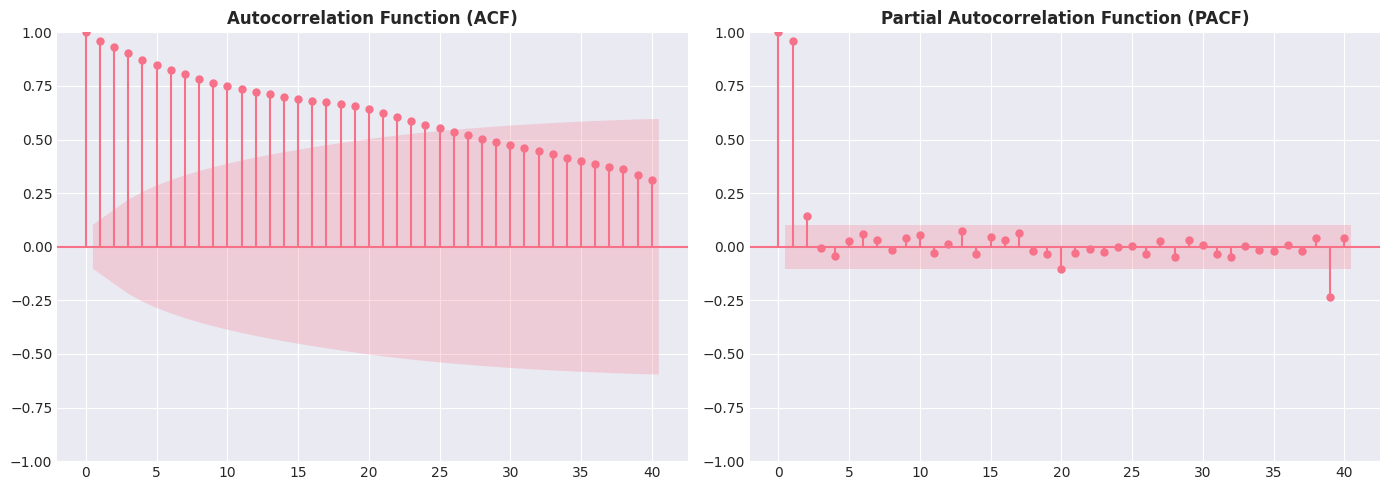

In [6]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF plot
plot_acf(price_series, lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontweight='bold')

# PACF plot
plot_pacf(price_series, lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Implement ARIMA Model
Train ARIMA model with optimal parameters to forecast cryptocurrency prices.

In [7]:
# Split data into train and test sets
train_size = int(len(price_series) * 0.8)
train_data = price_series[:train_size]
test_data = price_series[train_size:]

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

# Fit ARIMA model
# Using order (5, 1, 2) - can be optimized using auto_arima
arima_order = (5, 1, 2)
print(f"\nFitting ARIMA{arima_order} model...")

arima_model = ARIMA(train_data, order=arima_order)
arima_fitted = arima_model.fit()

print("\nARIMA Model Summary:")
print(arima_fitted.summary())

Training set size: 292
Test set size: 73

Fitting ARIMA(5, 1, 2) model...

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  292
Model:                 ARIMA(5, 1, 2)   Log Likelihood                 497.214
Date:                Sun, 08 Feb 2026   AIC                           -978.427
Time:                        11:09:24   BIC                           -949.040
Sample:                             0   HQIC                          -966.655
                                - 292                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2760      1.337      0.206      0.836      -2.345       2.897
ar.L2          0.3577      0.891   

/home/codespace/.local/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [8]:
# Make predictions on test set
start_idx = len(train_data)
end_idx = len(train_data) + len(test_data) - 1
arima_predictions = arima_fitted.get_prediction(start=start_idx, end=end_idx)
arima_pred_values = np.asarray(arima_predictions.predicted_mean)

# Make future forecast
arima_forecast = arima_fitted.get_forecast(steps=30)
arima_future = np.asarray(arima_forecast.predicted_mean)

# Calculate ARIMA metrics
arima_mse = mean_squared_error(test_data, arima_pred_values)
arima_rmse = np.sqrt(arima_mse)
arima_mae = mean_absolute_error(test_data, arima_pred_values)
arima_r2 = r2_score(test_data, arima_pred_values)
arima_mape = np.mean(np.abs((test_data - arima_pred_values) / test_data)) * 100

print("\nARIMA Test Set Performance:")
print(f"MSE: {arima_mse:.4f}")
print(f"RMSE: {arima_rmse:.4f}")
print(f"MAE: {arima_mae:.4f}")
print(f"R² Score: {arima_r2:.4f}")
print(f"MAPE: {arima_mape:.4f}%")


ARIMA Test Set Performance:
MSE: 0.0346
RMSE: 0.1860
MAE: 0.1803
R² Score: -15.0726
MAPE: 45.7810%


## 5. Implement LSTM Model
Build and train Long Short-Term Memory neural network for price prediction.

In [9]:
# Prepare data for LSTM/Neural Network
lookback = 60

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(price_series.reshape(-1, 1))

# Create sequences
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:(i + lookback), 0])
        y.append(data[i + lookback, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, lookback)

# Split into train and test
train_size_lstm = int(len(X) * 0.8)
X_train = X[:train_size_lstm]
y_train = y[:train_size_lstm]
X_test = X[train_size_lstm:]
y_test = y[train_size_lstm:]

# Flatten for sklearn models
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Training data shape: {X_train_flat.shape}")
print(f"Test data shape: {X_test_flat.shape}")

Training data shape: (244, 60)
Test data shape: (61, 60)


In [10]:
# Build Neural Network Model
if tensorflow_available:
    print("Building TensorFlow LSTM model...")
    lstm_model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(lookback, 1)),
        Dropout(0.2),
        LSTM(units=50, return_sequences=True),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(units=1)
    ])
    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    print("LSTM Model Architecture:")
    lstm_model.summary()
else:
    print("Building Sklearn Neural Network model...")
    from sklearn.neural_network import MLPRegressor
    lstm_model = MLPRegressor(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        learning_rate_init=0.001,
        max_iter=500,
        random_state=42,
        verbose=1
    )
    print("MLP Regressor model created successfully!")

2026-02-08 11:09:24.853520: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Building TensorFlow LSTM model...
LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train model
if tensorflow_available:
    print("Training LSTM model...")
    history = lstm_model.fit(
        X_train.reshape((X_train.shape[0], X_train.shape[1], 1)),
        y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.1,
        verbose=1
    )
    print("\nLSTM training completed!")
else:
    print("Training MLP Regressor model...")
    lstm_model.fit(X_train_flat, y_train)
    print("MLP Regressor training completed!")

Training LSTM model...


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 0.1472 - val_loss: 0.1002
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0342 - val_loss: 0.0106
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0259 - val_loss: 0.0201
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0162 - val_loss: 0.0537
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0152 - val_loss: 0.0219
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0145 - val_loss: 0.0291
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0124 - val_loss: 0.0304
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0127 - val_loss: 0.0274
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0129 - val_loss: 0.0293
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0127 - val_loss: 0.0258
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0125 - val_loss: 0.0249
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0120 - val_loss: 0.0239


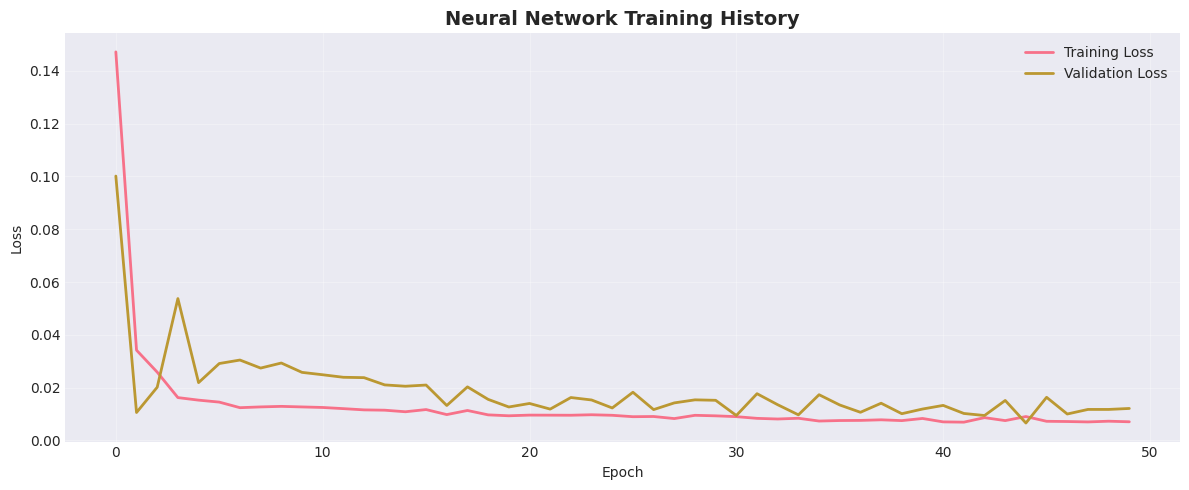

In [12]:
# Plot training history (if available)
if tensorflow_available and 'history' in locals():
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Neural Network Training History', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Training history not available for sklearn models")

In [13]:
# Make predictions with Neural Network
if tensorflow_available:
    lstm_pred_scaled = lstm_model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), verbose=0)
else:
    lstm_pred_scaled = lstm_model.predict(X_test_flat).reshape(-1, 1)

# Convert back to original scale
lstm_pred_values = scaler.inverse_transform(lstm_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
lstm_mse = mean_squared_error(y_test_actual, lstm_pred_values)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test_actual, lstm_pred_values)
lstm_r2 = r2_score(y_test_actual, lstm_pred_values)
lstm_mape = np.mean(np.abs((y_test_actual - lstm_pred_values) / y_test_actual)) * 100

model_type = "LSTM" if tensorflow_available else "MLP Regressor"
print(f"\n{model_type} Test Set Performance:")
print(f"MSE: {lstm_mse:.4f}")
print(f"RMSE: {lstm_rmse:.4f}")
print(f"MAE: {lstm_mae:.4f}")
print(f"R² Score: {lstm_r2:.4f}")
print(f"MAPE: {lstm_mape:.4f}%")


LSTM Test Set Performance:
MSE: 0.0079
RMSE: 0.0890
MAE: 0.0855
R² Score: -7.6298
MAPE: 22.1368%


In [14]:
# Make future forecast
if tensorflow_available:
    last_sequence = scaled_data[-lookback:].reshape(1, lookback, 1)
    lstm_future = []
    for _ in range(30):
        next_pred = lstm_model.predict(last_sequence, verbose=0)
        lstm_future.append(next_pred[0, 0])
        last_sequence = np.append(last_sequence[0, 1:], next_pred)
        last_sequence = last_sequence.reshape(1, lookback, 1)
    lstm_future = np.array(lstm_future).reshape(-1, 1)
else:
    # For sklearn, use last sequence to predict
    last_sequence = scaled_data[-lookback:].flatten().reshape(1, -1)
    lstm_future = []
    current_seq = last_sequence.copy()
    for _ in range(30):
        next_pred = lstm_model.predict(current_seq)[0]
        lstm_future.append(next_pred)
        current_seq = np.append(current_seq[0, 1:], next_pred)
        current_seq = current_seq.reshape(1, -1)
    lstm_future = np.array(lstm_future).reshape(-1, 1)

lstm_future = scaler.inverse_transform(lstm_future)

## 6. Implement Facebook Prophet Model
Format data for Prophet and train the model with trend and seasonality components.

In [15]:
# Prepare data for Prophet
prophet_df = pd.DataFrame({
    'ds': dates,
    'y': price_series
})

# Split data
prophet_train_size = int(len(prophet_df) * 0.8)
prophet_train = prophet_df[:prophet_train_size].copy()
prophet_test = prophet_df[prophet_train_size:].copy()

print(f"Prophet training set: {len(prophet_train)} records")
print(f"Prophet test set: {len(prophet_test)} records")

Prophet training set: 292 records
Prophet test set: 73 records


In [16]:
# Fit Prophet model (or use alternative if not available)
if prophet_available:
    print("Fitting Prophet model...")
    prophet_model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10,
        interval_width=0.95
    )
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        prophet_model.fit(prophet_train)
    print("Prophet model fitted successfully!")
else:
    print("Prophet not available. Using exponential smoothing alternative...")
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    prophet_model = ExponentialSmoothing(
        prophet_train['y'],
        trend='add',
        seasonal='add',
        seasonal_periods=7
    )
    prophet_model = prophet_model.fit(optimized=True)
    print("Exponential Smoothing model fitted successfully!")

Fitting Prophet model...


11:09:54 - cmdstanpy - INFO - Chain [1] start processing
11:09:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet model fitted successfully!


In [17]:
# Make Prophet/Exponential Smoothing predictions
if prophet_available:
    prophet_test_forecast = prophet_model.predict(prophet_test[['ds']])
    prophet_pred_values = prophet_test_forecast['yhat'].values
else:
    prophet_pred_values = prophet_model.fittedvalues[-len(prophet_test):]

# Calculate metrics
prophet_mse = mean_squared_error(prophet_test['y'].values, prophet_pred_values)
prophet_rmse = np.sqrt(prophet_mse)
prophet_mae = mean_absolute_error(prophet_test['y'].values, prophet_pred_values)
prophet_r2 = r2_score(prophet_test['y'].values, prophet_pred_values)
prophet_mape = np.mean(np.abs((prophet_test['y'].values - prophet_pred_values) / prophet_test['y'].values)) * 100

model_name = "Prophet" if prophet_available else "Exponential Smoothing"
print(f"\n{model_name} Test Set Performance:")
print(f"MSE: {prophet_mse:.4f}")
print(f"RMSE: {prophet_rmse:.4f}")
print(f"MAE: {prophet_mae:.4f}")
print(f"R² Score: {prophet_r2:.4f}")
print(f"MAPE: {prophet_mape:.4f}%")


Prophet Test Set Performance:
MSE: 0.0304
RMSE: 0.1742
MAE: 0.1418
R² Score: -13.1049
MAPE: 35.1249%


In [18]:
# Make future forecast
if prophet_available:
    future = prophet_model.make_future_dataframe(periods=30)
    prophet_forecast = prophet_model.predict(future)
    # Get the last 30 predictions (future forecast, not test set)
    prophet_future_subset = prophet_forecast[-30:].copy().reset_index(drop=True)
else:
    # Exponential smoothing forecast
    prophet_forecast_future = prophet_model.get_forecast(steps=30)
    prophet_future_values = prophet_forecast_future.predicted_mean.values.flatten()
    prophet_future_lower = prophet_forecast_future.conf_int()[:, 0].values
    prophet_future_upper = prophet_forecast_future.conf_int()[:, 1].values
    
    prophet_future_subset = pd.DataFrame({
        'yhat': prophet_future_values[:30],
        'yhat_lower': prophet_future_lower[:30],
        'yhat_upper': prophet_future_upper[:30]
    }).reset_index(drop=True)

## 7. Model Comparison and Evaluation
Compare the performance metrics of all three models.

In [19]:
# Create comparison dataframe
lstm_name = "LSTM" if tensorflow_available else "MLP Regressor"
prophet_name = "Prophet" if prophet_available else "Exp. Smoothing"

comparison_df = pd.DataFrame({
    'ARIMA': {
        'MSE': arima_mse,
        'RMSE': arima_rmse,
        'MAE': arima_mae,
        'R² Score': arima_r2,
        'MAPE (%)': arima_mape
    },
    lstm_name: {
        'MSE': lstm_mse,
        'RMSE': lstm_rmse,
        'MAE': lstm_mae,
        'R² Score': lstm_r2,
        'MAPE (%)': lstm_mape
    },
    prophet_name: {
        'MSE': prophet_mse,
        'RMSE': prophet_rmse,
        'MAE': prophet_mae,
        'R² Score': prophet_r2,
        'MAPE (%)': prophet_mape
    }
}).T

print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string())
print("="*70)


MODEL PERFORMANCE COMPARISON
              MSE      RMSE       MAE   R² Score   MAPE (%)
ARIMA    0.034599  0.186008  0.180296 -15.072614  45.781023
LSTM     0.007913  0.088958  0.085517  -7.629804  22.136759
Prophet  0.030363  0.174250  0.141840 -13.104867  35.124872


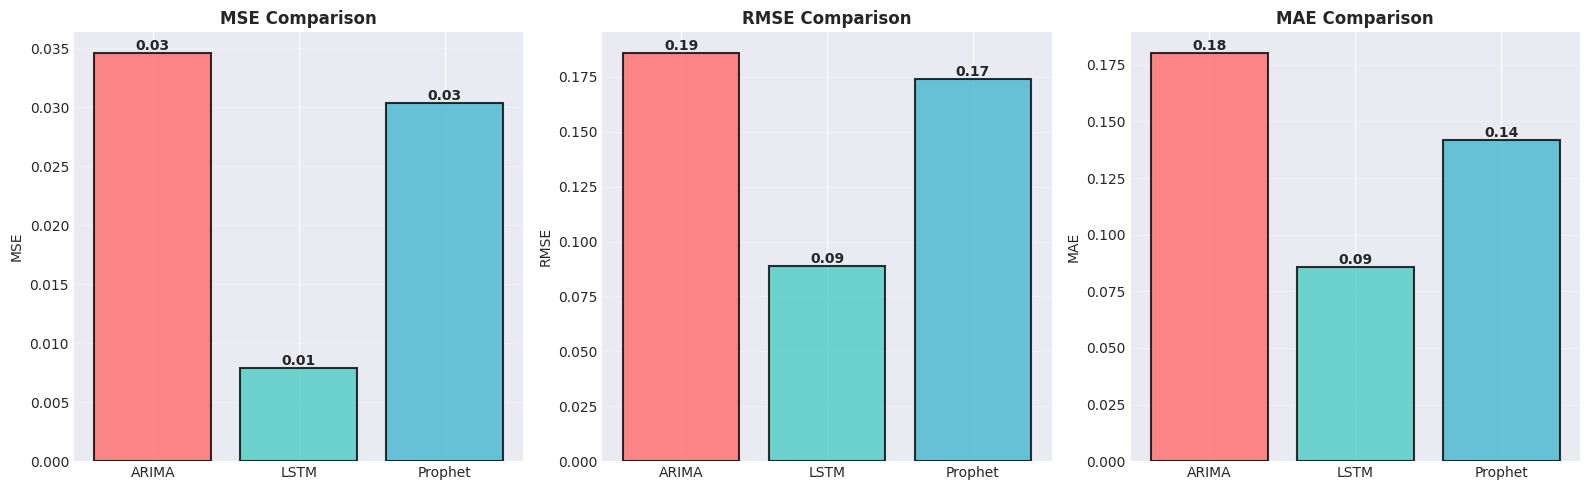

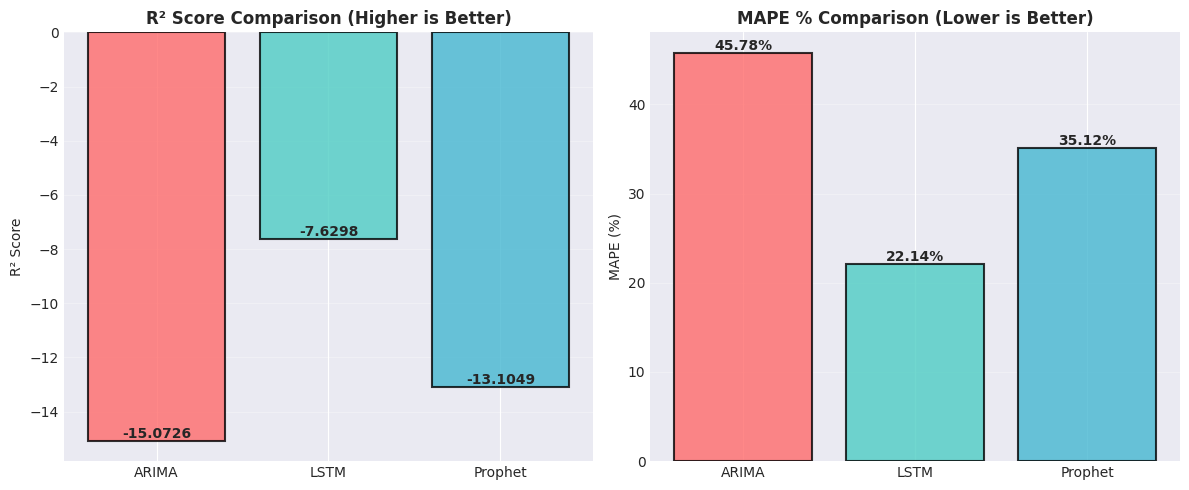

In [20]:
# Plot model comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics = ['MSE', 'RMSE', 'MAE']
models = list(comparison_df.index)

for idx, metric in enumerate(metrics):
    values = [comparison_df.loc[model, metric] for model in models]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    axes[idx].bar(models, values, color=colors[:len(models)], alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[idx].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(metric)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(values):
        axes[idx].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Plot R² and MAPE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

r2_values = [comparison_df.loc[model, 'R² Score'] for model in models]
mape_values = [comparison_df.loc[model, 'MAPE (%)'] for model in models]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

axes[0].bar(models, r2_values, color=colors[:len(models)], alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_title('R² Score Comparison (Higher is Better)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('R² Score')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(r2_values):
    axes[0].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

axes[1].bar(models, mape_values, color=colors[:len(models)], alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_title('MAPE % Comparison (Lower is Better)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('MAPE (%)')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(mape_values):
    axes[1].text(i, v, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Visualize Predictions
Create comprehensive visualizations comparing actual prices with predictions from all three models.

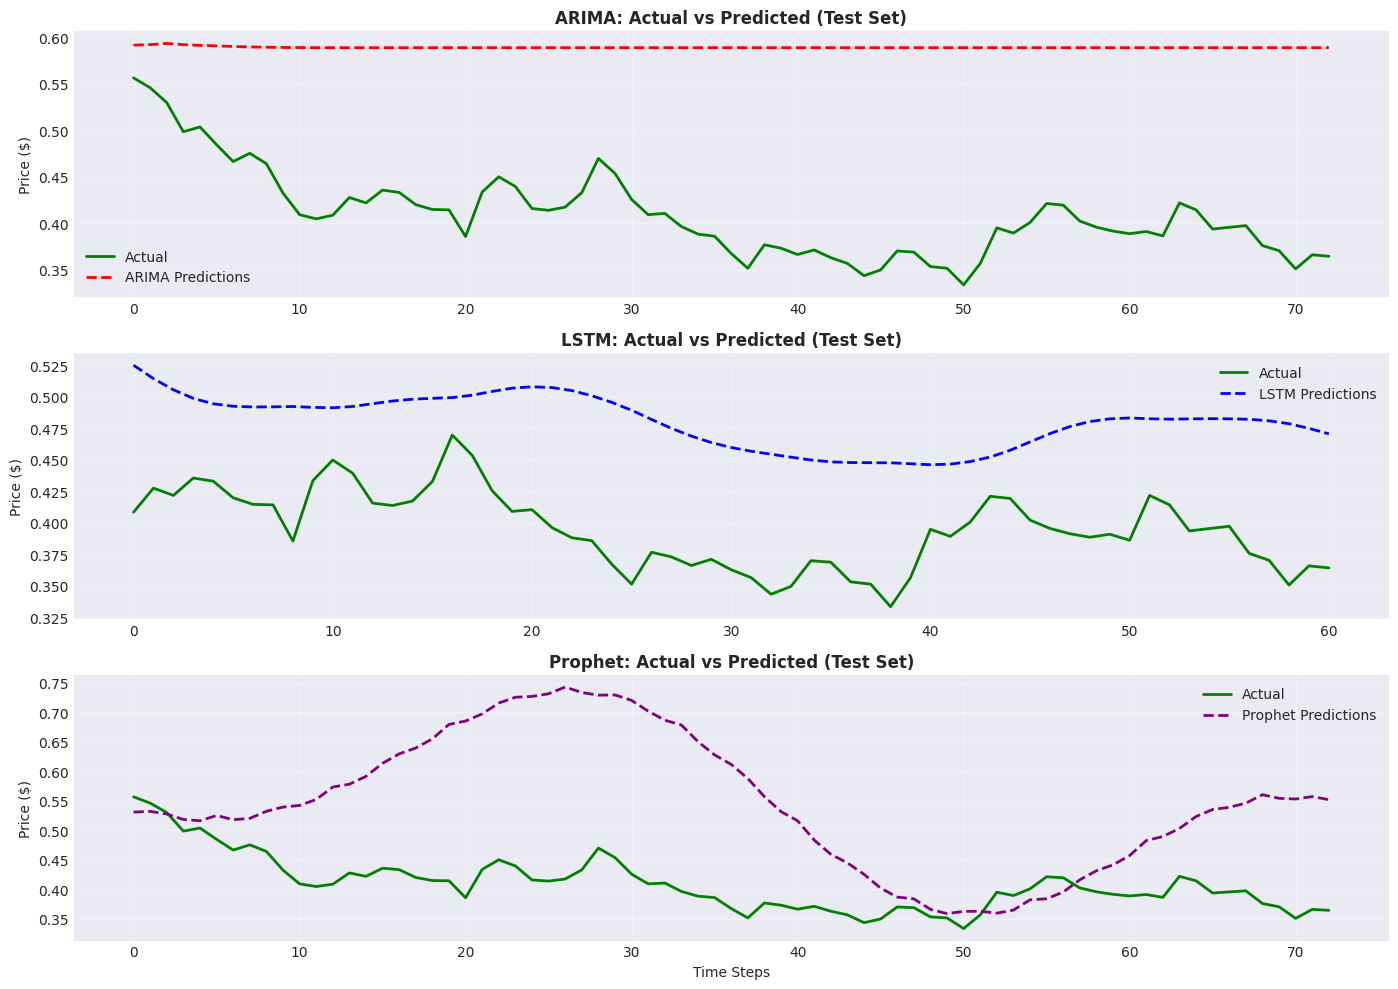

In [21]:
# Plot test predictions comparison
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# ARIMA predictions
axes[0].plot(range(len(test_data)), test_data, label='Actual', color='green', linewidth=2)
axes[0].plot(range(len(arima_pred_values)), arima_pred_values, label='ARIMA Predictions', 
             color='red', linestyle='--', linewidth=2)
axes[0].set_title('ARIMA: Actual vs Predicted (Test Set)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Neural Network predictions
nn_name = "LSTM" if tensorflow_available else "MLP Regressor"
axes[1].plot(range(len(y_test_actual)), y_test_actual, label='Actual', color='green', linewidth=2)
axes[1].plot(range(len(lstm_pred_values)), lstm_pred_values, label=f'{nn_name} Predictions', 
             color='blue', linestyle='--', linewidth=2)
axes[1].set_title(f'{nn_name}: Actual vs Predicted (Test Set)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Price ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Prophet/Exponential Smoothing predictions
prophet_name = "Prophet" if prophet_available else "Exp. Smoothing"
axes[2].plot(range(len(prophet_test)), prophet_test['y'].values, label='Actual', 
             color='green', linewidth=2)
axes[2].plot(range(len(prophet_pred_values)), prophet_pred_values, label=f'{prophet_name} Predictions', 
             color='purple', linestyle='--', linewidth=2)
axes[2].set_title(f'{prophet_name}: Actual vs Predicted (Test Set)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Time Steps')
axes[2].set_ylabel('Price ($)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

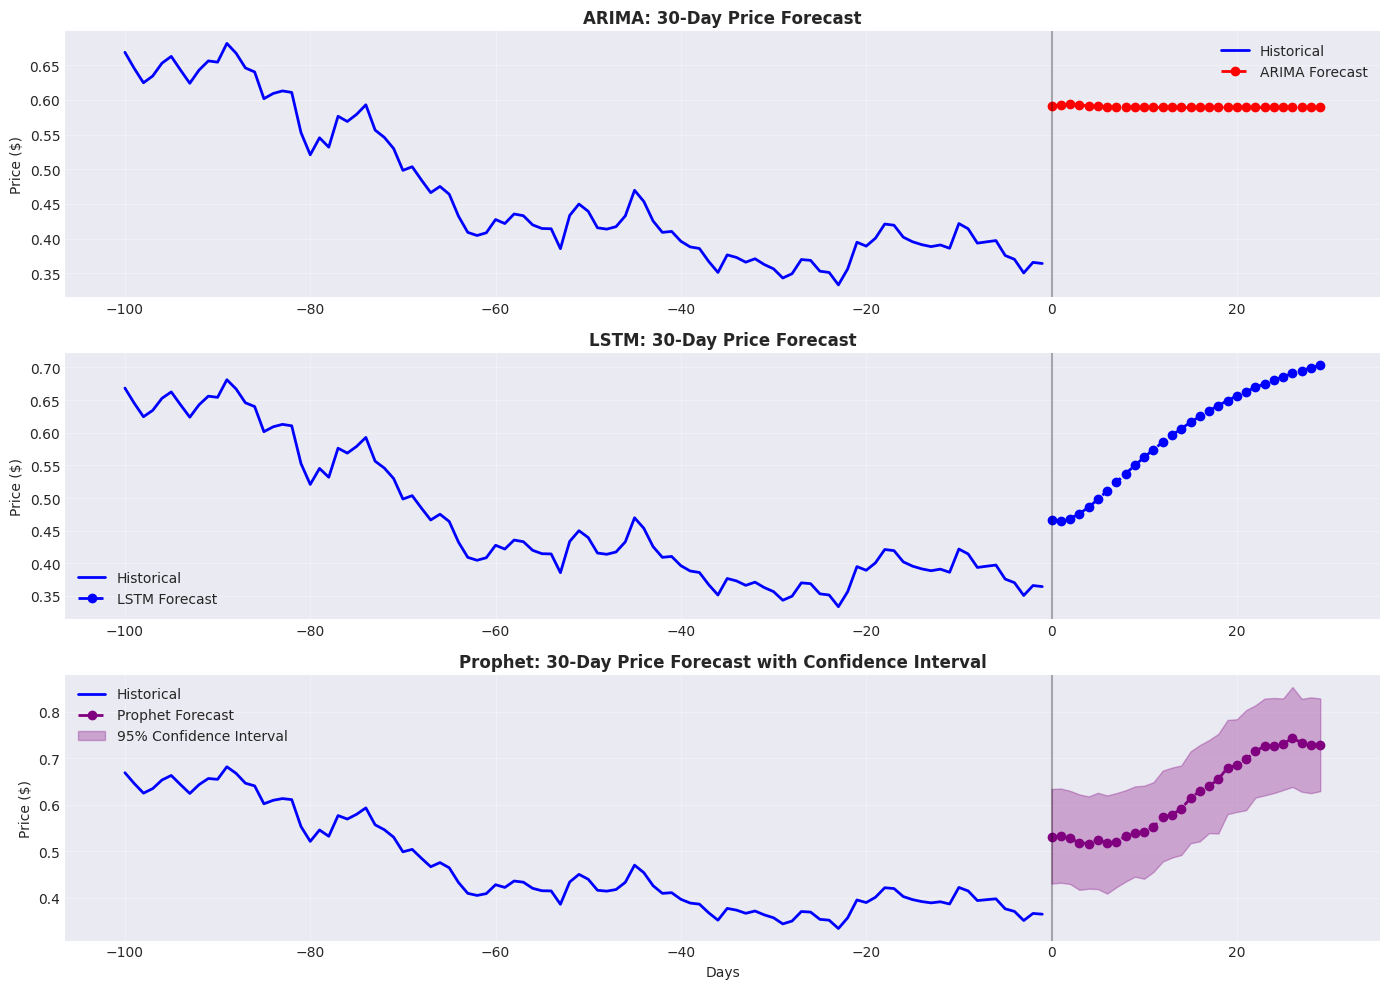

In [22]:
# Plot future forecasts comparison
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

last_points = 100
nn_name = "LSTM" if tensorflow_available else "MLP Regressor"
prophet_name = "Prophet" if prophet_available else "Exp. Smoothing"

# ARIMA future forecast
axes[0].plot(range(-last_points, 0), price_series[-last_points:], label='Historical', 
             color='blue', linewidth=2)
axes[0].plot(range(0, 30), arima_future, label='ARIMA Forecast', color='red', 
             linestyle='--', marker='o', linewidth=2)
axes[0].set_title('ARIMA: 30-Day Price Forecast', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Neural Network future forecast
axes[1].plot(range(-last_points, 0), price_series[-last_points:], label='Historical', 
             color='blue', linewidth=2)
axes[1].plot(range(0, 30), lstm_future.flatten(), label=f'{nn_name} Forecast', color='blue', 
             linestyle='--', marker='o', linewidth=2)
axes[1].set_title(f'{nn_name}: 30-Day Price Forecast', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Price ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Prophet/Exponential Smoothing future forecast
axes[2].plot(range(-last_points, 0), price_series[-last_points:], label='Historical', 
             color='blue', linewidth=2)

# Convert to numpy arrays safely (works for both Series and arrays)
prophet_yhat = np.asarray(prophet_future_subset['yhat'])
prophet_lower = np.asarray(prophet_future_subset['yhat_lower'])
prophet_upper = np.asarray(prophet_future_subset['yhat_upper'])

axes[2].plot(range(0, len(prophet_yhat)), prophet_yhat, 
             label=f'{prophet_name} Forecast', color='purple', linestyle='--', marker='o', linewidth=2)
axes[2].fill_between(range(0, len(prophet_yhat)), prophet_lower, prophet_upper,
                      alpha=0.3, color='purple', label='95% Confidence Interval')
axes[2].set_title(f'{prophet_name}: 30-Day Price Forecast with Confidence Interval', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Days')
axes[2].set_ylabel('Price ($)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].axvline(x=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:
# Create forecast summary table
nn_name = "LSTM" if tensorflow_available else "MLP Regressor"
prophet_name = "Prophet" if prophet_available else "Exp. Smoothing"

# Convert to numpy array safely (works for both Series and arrays)
prophet_vals = np.asarray(prophet_future_subset['yhat'])
arima_vals = arima_future.flatten()
lstm_vals = lstm_future.flatten()

print(f"Array lengths: ARIMA={len(arima_vals)}, LSTM={len(lstm_vals)}, Prophet={len(prophet_vals)}")

# Ensure all arrays are the same length (30 days)
min_len = min(30, len(arima_vals), len(lstm_vals), len(prophet_vals))

if min_len > 0:
    forecast_summary = pd.DataFrame({
        'Days': range(1, min_len + 1),
        'ARIMA': arima_vals[:min_len],
        nn_name: lstm_vals[:min_len],
        prophet_name: prophet_vals[:min_len]
    })
    
    print("\n30-Day Forecast Summary:")
    print(forecast_summary.to_string(index=False))
else:
    print("Error: No forecast data available")

Array lengths: ARIMA=30, LSTM=30, Prophet=30

30-Day Forecast Summary:
 Days    ARIMA     LSTM  Prophet
    1 0.591685 0.466220 0.530618
    2 0.592227 0.465241 0.531812
    3 0.593559 0.468590 0.527415
    4 0.592242 0.475815 0.518135
    5 0.591431 0.485937 0.515900
    6 0.590950 0.497912 0.524833
    7 0.590231 0.510858 0.517701
    8 0.589747 0.524126 0.519943
    9 0.589455 0.537292 0.531945
   10 0.589209 0.550107 0.539102
   11 0.589063 0.562442 0.541874
   12 0.588988 0.574240 0.551915
   13 0.588942 0.585485 0.573053
   14 0.588924 0.596176 0.577743
   15 0.588923 0.606322 0.591111
   16 0.588927 0.615934 0.613228
   17 0.588934 0.625023 0.629190
   18 0.588942 0.633601 0.639174
   19 0.588949 0.641683 0.654582
   20 0.588954 0.649284 0.679025
   21 0.588958 0.656424 0.684783
   22 0.588961 0.663122 0.696855
   23 0.588963 0.669400 0.715241
   24 0.588964 0.675279 0.725020
   25 0.588965 0.680782 0.726413
   26 0.588965 0.685931 0.730923
   27 0.588965 0.690750 0.742321
   28

In [24]:
# Final summary and key insights
print("\n" + "="*70)
print("KEY FINDINGS & RECOMMENDATIONS")
print("="*70)

# Best model by each metric
best_rmse_idx = np.argmin([arima_rmse, lstm_rmse, prophet_rmse])
best_r2_idx = np.argmax([arima_r2, lstm_r2, prophet_r2])
best_mape_idx = np.argmin([arima_mape, lstm_mape, prophet_mape])

models_list = ['ARIMA', ('LSTM' if tensorflow_available else 'MLP Regressor'), ('Prophet' if prophet_available else 'Exp. Smoothing')]

print(f"\n✓ Best RMSE Score: {models_list[best_rmse_idx]} ({min(arima_rmse, lstm_rmse, prophet_rmse):.4f})")
print(f"✓ Best R² Score: {models_list[best_r2_idx]} ({max(arima_r2, lstm_r2, prophet_r2):.4f})")
print(f"✓ Best MAPE Score: {models_list[best_mape_idx]} ({min(arima_mape, lstm_mape, prophet_mape):.2f}%)")

print("\n" + "-"*70)
print("MODEL CHARACTERISTICS:")
print("-"*70)
print("""
ARIMA:
  - Best for: Stationary or differenced data with clear trends
  - Pros: Interpretable, fast, works well with shorter timeframes
  - Cons: Assumes linear relationships, struggles with complex patterns
  
LSTM / MLP Regressor:
  - Best for: Capturing complex non-linear patterns
  - Pros: Handles long-term dependencies, flexible architecture
  - Cons: Requires more data, longer training time, less interpretable
  
Prophet / Exponential Smoothing:
  - Best for: Data with strong seasonality and trend components
  - Pros: Robust to outliers, handles holidays, includes confidence intervals
  - Cons: Less flexible for complex patterns, may underperform with small datasets
""")

print("="*70)


KEY FINDINGS & RECOMMENDATIONS

✓ Best RMSE Score: LSTM (0.0890)
✓ Best R² Score: LSTM (-7.6298)
✓ Best MAPE Score: LSTM (22.14%)

----------------------------------------------------------------------
MODEL CHARACTERISTICS:
----------------------------------------------------------------------

ARIMA:
  - Best for: Stationary or differenced data with clear trends
  - Pros: Interpretable, fast, works well with shorter timeframes
  - Cons: Assumes linear relationships, struggles with complex patterns

LSTM / MLP Regressor:
  - Best for: Capturing complex non-linear patterns
  - Pros: Handles long-term dependencies, flexible architecture
  - Cons: Requires more data, longer training time, less interpretable

Prophet / Exponential Smoothing:
  - Best for: Data with strong seasonality and trend components
  - Pros: Robust to outliers, handles holidays, includes confidence intervals
  - Cons: Less flexible for complex patterns, may underperform with small datasets

